# Custom image augmentation

In this workbook, I create some of my own custom image augmentation (such as different image filtering techniques) rather than solely using those predefined by Keras’ ImageDataGenerator.  This code is based on ["Extending the ImageDataGenerator in Keras and TensorFlow"](https://www.analyticsvidhya.com/blog/2020/11/extending-the-imagedatagenerator-keras-tensorflow/), by Raman70.  We do this with a preprocessing argument.  In a sense, we are not augmenting the data since it is being applied to all the images.  But, with some work, we could apply it to only some images.  The principle still works.

In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from random import sample 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

from scipy.ndimage.filters import convolve

## Do some early processing of your metadata for easier model training:

In [10]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

Scans found: 112120 , Total Headers 112120


In [17]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

In [18]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

def get_pneumonia_class(row):
    if row['Pneumonia'] < 0.5:
        return "no-pneumonia"
    else:
        return "pneumonia"

all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda row: get_pneumonia_class(row), axis=1)

## Create your training and testing data:

In [19]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data = skl.train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['pneumonia_class'])
    
    return train_data, val_data

In [22]:
train_df, valid_df = create_splits(all_xray_df)

Great, our train_test_split made sure that we had the same proportions of pneumonia in both sets!

### Condition 1 - To have _EQUAL_ amount of positive and negative cases of pneumonia in Training 
But.... we know that we want our model to be trained on a set that has _equal_ proportions of pneumonia and no pneumonia, so we're going to have to throw away some data:

In [25]:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

Ta-da! We randomly chose a set of non-pneumonia images using the sample() function that was the same length as the number of true pneumonia cases we had, and then we threw out the rest of the non-pneumonia cases. Now our training dataset is balanced 50-50.

### Condition 2 - To have 20% positive cases of Pneumonia in the Test Set
Finally, we want to make the balance in our validation set more like 1:4.

In [26]:
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

In [27]:
# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds, 4 * len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]

In [28]:
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [29]:
## you can choose an image size to resize your images to during augmentation, which comes in handy later when you
## want to do deep learning using a pre-trained CNN that has a specified size input layer
IMG_SIZE = (224, 224)

In [70]:
def preprocessing_fun(img):
    # Process image
    # We will use an embossing convolution.  This will make the edges 'harder'.
    kernel = np.array([[[0,-2,0],[0,-1,0],[0,0,0]],
                       [[0,-1,0],[0,1,0],[0,1,0]],
                       [[0,0,0],[0,1,0],[0,2,0]]])
    im2 = convolve(img, kernel)
    im3 = np.array(np.clip(im2, 0, 255)) 
    return im3

In [71]:
def my_image_augmentation(**vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## We next implement some of out own custom augmentation that's *not*
    ## built into something like a Keras package.  We do this by calling a preprocessing function.  
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                           preprocessing_function = preprocessing_fun)
    
    return my_idg


def make_train_gen(my_train_idg, train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = IMG_SIZE, 
                                          batch_size = 16)
    return train_gen

In [72]:
train_idg = my_image_augmentation(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

In [73]:
train_gen = make_train_gen(train_idg, train_df)

Found 2290 validated image filenames belonging to 2 classes.


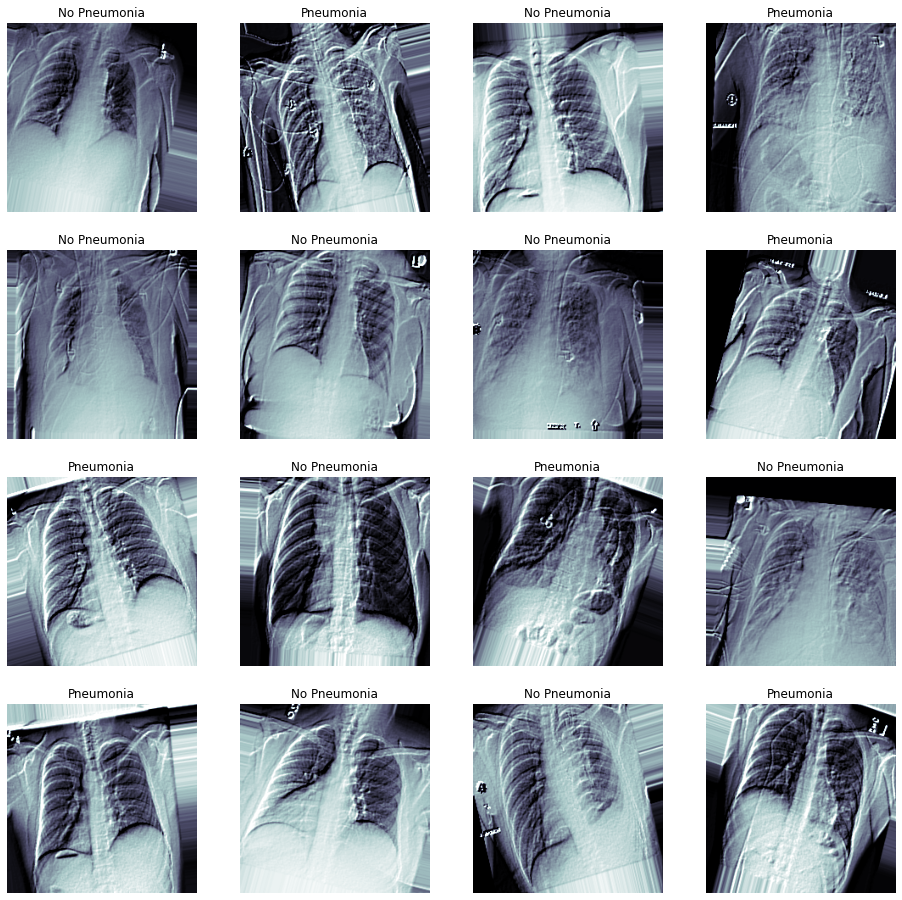

In [74]:
## Notice the 'embossed appearance of the images'

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 0: 
        c_ax.set_title('No Pneumonia')
    else:
        c_ax.set_title('Pneumonia')
    c_ax.axis('off')